# Graph Convolutional Networks

The Graph Convolutional Network (GCN) architecture, introduced by Kipf and Welling in 2017, is an efficient variant of Convolutional Neural Networks (CNNs) applied to graphs. It approximates a graph convolution operation in graph signal processing and has become the most popular Graph Neural Network (GNN) in scientific literature due to its versatility and ease of use.

![](img/distill-GCN.png)

This chapter discusses the limitations of a vanilla GNN layer and explains the motivation behind GCNs. It details how the GCN layer works and why it performs better, demonstrated through implementations on the Cora and Facebook Page-Page datasets using PyTorch Geometric.

## Overview of GCNs  

Graph Convolutional Networks (GCNs) extend the concept of convolutional networks to graph-structured data. The key idea is to perform convolution operations on graphs, which allows the model to learn localized features from neighboring nodes.   

### Motivation  

While traditional Convolutional Neural Networks (CNNs) operate on grid-like data (like images), many real-world applications involve non-Euclidean structures, such as social networks, molecular structures, and citation networks. GCNs provide a way to leverage the connectivity information in these graphs to extract meaningful patterns.  

## GCN Layer Definition  

A GCN layer is defined as follows:  

$$  
\mathbf{H}^{(l)} = \sigma(\tilde{\mathbf{A}} \mathbf{H}^{(l-1)} \mathbf{W}^{(l)})  
$$  

Where:  
- $ \mathbf{H}^{(l)} $ is the matrix of node representations at layer $ l $.  
- $ \tilde{\mathbf{A}} $ is the modified adjacency matrix.  
- $ \mathbf{H}^{(l-1)} $ is the matrix of node representations from the previous layer.  
- $ \mathbf{W}^{(l)} $ is the weight matrix for layer $ l $.  
- $ \sigma $ is an activation function (commonly ReLU).  

### Modified Adjacency Matrix  

The modified adjacency matrix $ \tilde{\mathbf{A}} $ incorporates self-loops to include the node’s own features in the aggregation:  

$$  
\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I}  
$$  

Where:  
- $ \mathbf{I} $ is the identity matrix, ensuring that each node's own features are included in the update.  

To maintain numerical stability and ensure that the updated representations have a manageable scale, we usually normalize $ \tilde{\mathbf{A}} $ as follows:  

$$  
\tilde{\mathbf{A}}_{\text{norm}} = D^{-1/2} \tilde{\mathbf{A}} D^{-1/2}  
$$  

Where $ D $ is the degree matrix of the graph, with $ D_{ii} = \sum_j \tilde{A}_{ij} $.  

## GCN Layer Operation  

1. **Aggregation**: The initial representation of a node is transformed by its neighbors, including itself:  

$$  
\mathbf{H}^{(l)} = \tilde{\mathbf{A}}_{\text{norm}} \mathbf{H}^{(l-1)} \mathbf{W}^{(l)}  
$$  

2. **Activation**: After the aggregation step, an activation function is applied to introduce non-linearity:  

$$  
\mathbf{H}^{(l)} = \sigma(\tilde{\mathbf{A}}_{\text{norm}} \mathbf{H}^{(l-1)} \mathbf{W}^{(l)})  
$$  

In [11]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import numpy as np
np.random.seed(0)

D = np.array([
    [3, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 2, 0],
    [0, 0, 0, 2]
])

In [3]:
np.linalg.inv(D)

array([[0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.5       ]])

In [4]:
np.linalg.inv(D + np.identity(4))

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [5]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
])

print(np.linalg.inv(D + np.identity(4)) @ A)
print()
print(A @ np.linalg.inv(D + np.identity(4)))

[[0.25       0.25       0.25       0.25      ]
 [0.5        0.5        0.         0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]]

[[0.25       0.5        0.33333333 0.33333333]
 [0.25       0.5        0.         0.        ]
 [0.25       0.         0.33333333 0.33333333]
 [0.25       0.         0.33333333 0.33333333]]


<BarContainer object of 37 artists>

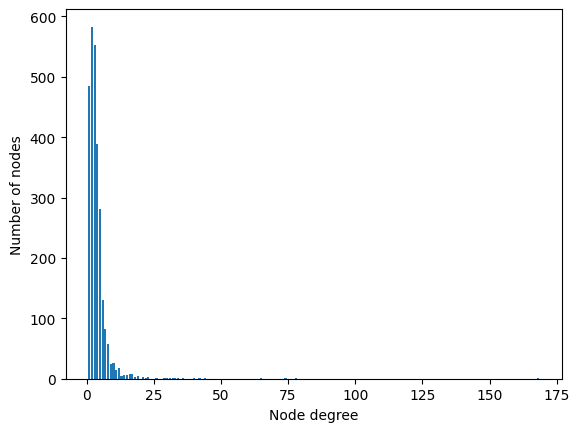

In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

# Import dataset from PyTorch Geometric
dataset = Planetoid(root="../../data", name="Cora")
data = dataset[0]

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

Rather than implementing the GCN layer from scratch, we leverage the `GCNConv` module available in PyTorch Geometric. This pre-built module provides an efficient and optimized implementation of the GCN layer, allowing us to focus on higher-level design and experimentation without the complexities of low-level coding.

In [9]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root="../../data", name="Cora")
data = dataset[0]

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, epochs=100)

# Test
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.932 | Train Acc: 15.71% | Val Loss: 1.94 | Val Acc: 15.20%
Epoch  20 | Train Loss: 0.099 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc: 77.80%
Epoch  40 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.015 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.80%
Epoch  80 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.40%

GCN test accuracy: 79.70%



### Facebook data

In [ ]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root="../../data/Facebook")
data = dataset[0]

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [10]:
# Load Facebook Page-Page
dataset = FacebookPagePage(root="../../data/Facebook")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

# Train GCN
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)
gcn.fit(data, epochs=100)
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.463 | Train Acc: 20.72% | Val Loss: 1.45 | Val Acc: 20.71%
Epoch  20 | Train Loss: 0.443 | Train Acc: 84.64% | Val Loss: 0.43 | Val Acc: 85.29%
Epoch  40 | Train Loss: 0.323 | Train Acc: 89.59% | Val Loss: 0.31 | Val Acc: 90.20%
Epoch  60 | Train Loss: 0.278 | Train Acc: 91.34% | Val Loss: 0.27 | Val Acc: 91.55%
Epoch  80 | Train Loss: 0.254 | Train Acc: 92.28% | Val Loss: 0.26 | Val Acc: 92.75%
Epoch 100 | Train Loss: 0.238 | Train Acc: 92.82% | Val Loss: 0.25 | Val Acc: 92.75%

GCN test accuracy: 91.70%



Summary of accuracy scores with standard deviation:

![](img/Summary-accuracy-MLP-GNN-GCN.png)


## Summary  

1. **Graph Structure**: GCNs operate on graph-structured data, which is represented as nodes and edges.  
2. **Node Features**: Each node has an initial feature vector, and these features are updated iteratively.  
3. **Modified Adjacency Matrix**: The adjacency matrix is modified to include self-loops and normalized to stabilize learning.  
4. **Layer Operation**: The GCN layer aggregates features from neighboring nodes and updates the node representations using shared weights.  
5. **Iterative Learning**: By stacking multiple GCN layers, the model can learn increasingly abstract representations of the graph.  

The GCN framework lays the groundwork for many applications in node classification, link prediction, and graph classification tasks by effectively capturing the structural information of the graph.

Other examples ...

In [10]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root="../../data", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

In [11]:
import pandas as pd

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
values = np.log10(df['target'])
data.y = torch.tensor(values)
data.y

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

<BarContainer object of 63 artists>

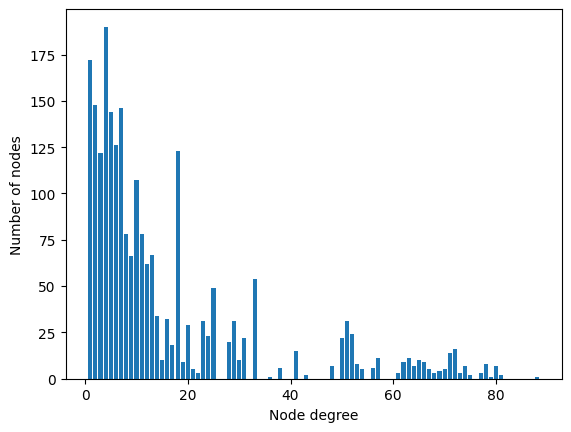

In [12]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

C:\Users\labon\AppData\Local\Temp\ipykernel_5392\2660044443.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['target'], fit=norm)


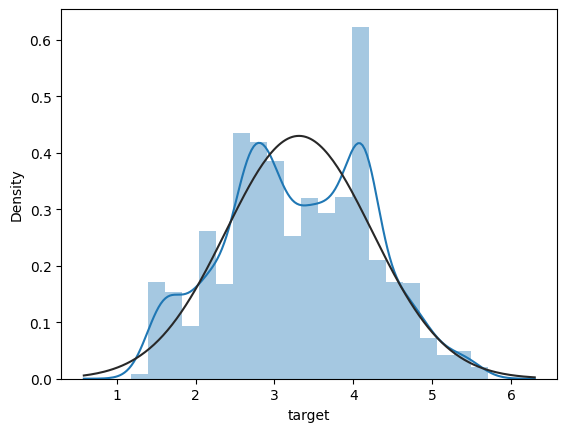

In [13]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

In [14]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h

    def fit(self, data, epochs): 
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.02,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
                print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 128, 1)
print(gcn) 

# Train
gcn.fit(data, epochs=200)

# Test
loss = gcn.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 12.84923 | Val Loss: 13.00931
Epoch  20 | Train Loss: 10.88506 | Val Loss: 10.90778
Epoch  40 | Train Loss: 4.79482 | Val Loss: 5.28797
Epoch  60 | Train Loss: 1.39142 | Val Loss: 2.00964
Epoch  80 | Train Loss: 0.69881 | Val Loss: 0.93502
Epoch 100 | Train Loss: 0.48443 | Val Loss: 0.83363
Epoch 120 | Train Loss: 0.41669 | Val Loss: 0.78679
Epoch 140 | Train Loss: 0.42846 | Val Loss: 0.78785
Epoch 160 | Train Loss: 0.38060 | Val Loss: 0.79018
Epoch 180 | Train Loss: 0.35250 | Val Loss: 0.67915
Epoch 200 | Train Loss: 0.33834 | Val Loss: 0.75305

GCN test loss: 0.75656



In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7566 | RMSE = 0.8698 | MAE = 0.6758


[Text(0.5, 0, 'Ground truth'), Text(0, 0.5, 'Predicted values')]

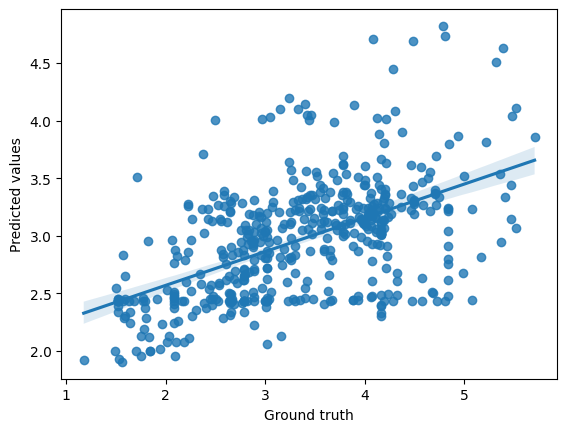

In [16]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')